# Downloading Dataset

In [ ]:
!pip install -q gdown

# Fold1_part1.zip: https://drive.google.com/file/d/16x8afSOwfbdGAjUbfRFvwGj1ie8Lf5Do/view?usp=drive_link

file_id = "16x8afSOwfbdGAjUbfRFvwGj1ie8Lf5Do"
output_zip = "Fold1_part1.zip"

!gdown --id {file_id} -O {output_zip}

!unzip -q {output_zip} -d unzipped_data

!rm Fold1_part1.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=16x8afSOwfbdGAjUbfRFvwGj1ie8Lf5Do
From (redirected): https://drive.google.com/uc?id=16x8afSOwfbdGAjUbfRFvwGj1ie8Lf5Do&confirm=t&uuid=8098c3bd-ba07-4c25-b0aa-67a336765520
To: /content/Fold1_part1.zip
100% 12.9G/12.9G [03:40<00:00, 58.4MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Creating Custom Dataset and Dataloader

In [ ]:
import re
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import time
from pathlib import Path
import math
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# hyperparameters
DATA_ROOT = "/content/unzipped_data"
WINDOW_SIZE = 16
STRIDE = 8
BATCH_SIZE = 8
NUM_EPOCHS = 10
LEARNING_RATE = 0.0005
MODEL_DIR = "drowsiness_models"

In [ ]:
class SlidingWindowDrowsinessDataset(Dataset):
    def __init__(self, root_dir, window_size=16, stride=8, transform=None):
        """
        Dataset for drowsiness detection using sliding windows over videos.

        Args:
            root_dir: Directory containing video files
            window_size: Number of frames in each sliding window
            stride: Step size for sliding window (in frames)
            transform: Transforms to apply to frames
        """
        self.root_dir = root_dir
        self.window_size = window_size
        self.stride = stride
        self.transform = transform
        self.video_paths = []
        self.video_labels = []
        self.window_indices = []
        self.video_frame_counts = []

        # Scan the directory to build dataset index
        self._scan_directory()

    def _scan_directory(self):
        # Accepted extensions
        valid_extensions = ['.mov', '.MOV', '.mp4']

        # Traverse and collect video paths with accepted extensions
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if any(file.endswith(ext) for ext in valid_extensions):
                    file_path = os.path.join(root, file)

                    # Determine label based on filename
                    basename = os.path.basename(file_path).lower()

                    match = re.search(r'(\d+)\.(mov|mp4)$', basename)
                    if match:
                        num = match.group(1)
                        if num == "10":
                            label = 1  # Drowsy
                        elif num == "0":
                            label = 0  # Alert
                        else:
                            continue
                    else:
                        continue

                    # Get frame count to determine sliding windows
                    cap = cv2.VideoCapture(file_path)
                    if not cap.isOpened():
                        print(f"Warning: Could not open video {file_path}")
                        continue

                    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                    cap.release()

                    if total_frames < self.window_size:
                        print(f"Warning: Video {file_path} has fewer frames ({total_frames}) than window size ({self.window_size}). Skipping.")
                        continue

                    # Add video and create sliding windows
                    video_idx = len(self.video_paths)
                    self.video_paths.append(file_path)
                    self.video_labels.append(label)
                    self.video_frame_counts.append(total_frames)

                    for start_frame in range(0, total_frames - self.window_size + 1, self.stride):
                        self.window_indices.append((video_idx, start_frame))

        if not self.video_paths:
            raise ValueError(f"No valid video files found in {self.root_dir}")

        print(f"Built dataset index with {len(self.video_paths)} videos, {len(self.window_indices)} sliding windows")

    def __len__(self):
        return len(self.window_indices)

    def __getitem__(self, idx):
        """Get a window of frames from a video"""
        video_idx, start_frame = self.window_indices[idx]
        video_path = self.video_paths[video_idx]
        label = self.video_labels[video_idx]

        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                raise ValueError(f"Could not open video {video_path}")

            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            if total_frames == 0:
                cap.release()
                raise ValueError(f"No frames found in video {video_path}")

            # Set position to start frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

            # Read window_size frames
            frames = []
            for _ in range(self.window_size):
                success, frame = cap.read()
                if not success:
                    if frames:
                        frames.append(frames[-1])
                    else:
                        cap.release()
                        raise ValueError(f"Failed to read frame from {video_path}")
                else:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = cv2.resize(frame, (224, 224))
                    if self.transform:
                        frame = self.transform(frame)
                    else:
                        frame = torch.from_numpy(frame).float().permute(2, 0, 1) / 255.0
                    frames.append(frame)

            cap.release()

            # Stack frames into a video tensor
            video_tensor = torch.stack(frames, dim=0)

            return video_tensor, label

        except Exception as e:
            print(f"Error reading video {video_path}: {e}")
            raise


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Initialize the dataset with sliding windows
dataset = SlidingWindowDrowsinessDataset(
    root_dir=DATA_ROOT,
    window_size=WINDOW_SIZE,    # Number of frames per window
    stride=STRIDE,          # Stride between windows (in frames)
    transform=transform
)

# Create data loader
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Test the loader
for videos, labels in loader:
    print(videos.shape)  # Expected: (batch_size, window_size, 3, 224, 224)
    print(labels)
    break

Built dataset index with 12 videos, 25530 sliding windows
torch.Size([8, 16, 3, 224, 224])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
from collections import Counter

class_counts = Counter()
for (video_idx, start_frame) in dataset.window_indices:
    label = dataset.video_labels[video_idx]
    class_counts[label] += 1

print("Number of inputs (sliding windows) per class:")
for label, count in class_counts.items():
    # Print using any custom names, e.g., 0: 'Alert', 1: 'Drowsy'
    class_name = 'Alert' if label == 0 else 'Drowsy'
    print(f"Class {label} ({class_name}): {count}")


Number of inputs (sliding windows) per class:
Class 1 (Drowsy): 12279
Class 0 (Alert): 13251


In [ ]:
def show_video_frames_grid(video_tensor, label=None, title="Video Frame Sequence"):
    """
    Display a 4x4 grid of frames from a single video tensor.

    Args:
        video_tensor (Tensor): A tensor of shape [T, C, H, W] representing the frames.
        label (int, optional): The class label (0 or 1).
        title (str, optional): Plot title.
    """
    frames = video_tensor.permute(0, 2, 3, 1).numpy()  # [T, H, W, C]
    num_frames = frames.shape[0]
    grid_size = 4

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    fig.suptitle(f"{title} | Label: {label}", fontsize=16)

    for i in range(grid_size * grid_size):
        row = i // grid_size
        col = i % grid_size
        ax = axes[row][col]

        if i < num_frames:
            ax.imshow(frames[i])
            ax.set_title(f"Frame {i+1}")
        else:
            ax.axis("off")

        ax.axis('off')

    plt.tight_layout()
    plt.show()


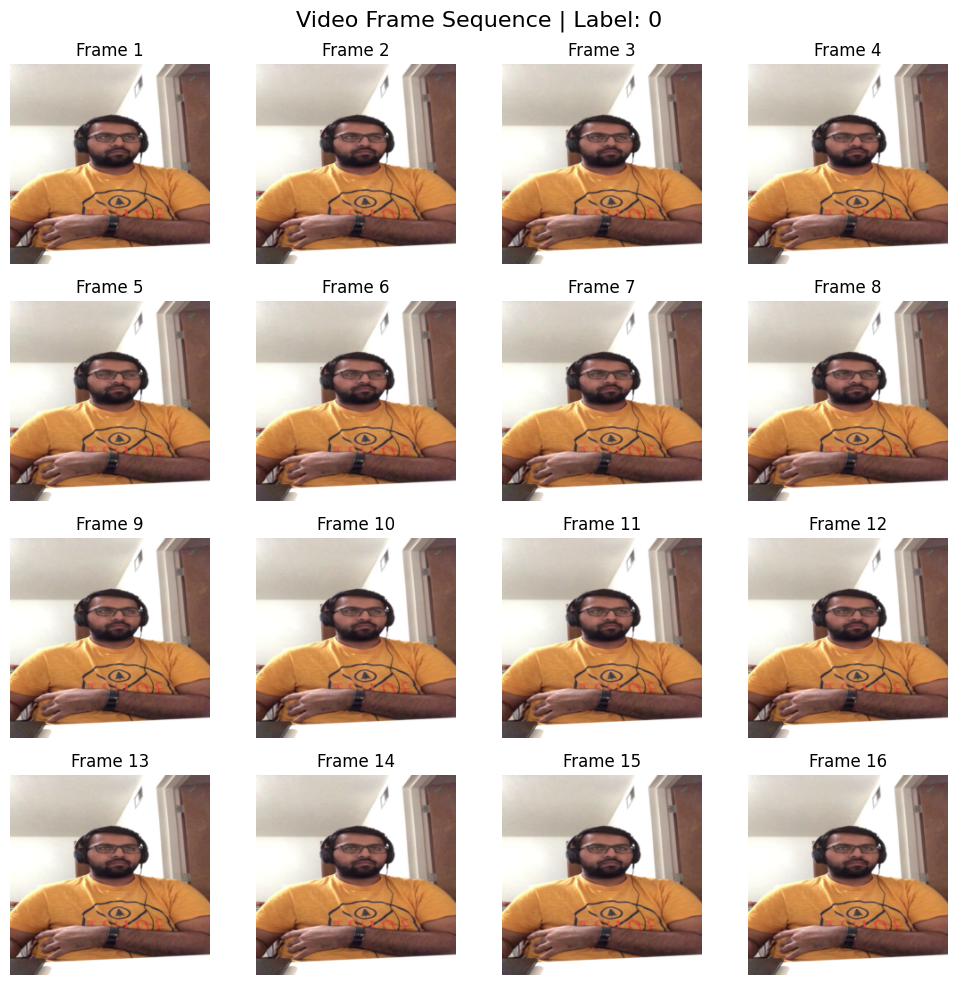

In [ ]:
# Get one batch from the dataloader
for batch in loader:
    videos, labels = batch  # videos: [B, T, C, H, W]
    show_video_frames_grid(videos[0], label=labels[0].item())
    break

In [ ]:
def create_train_val_test_split(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    """
    Create train, validation, and test splits from the dataset.

    Args:
        dataset: The full dataset
        train_ratio: Proportion for training
        val_ratio: Proportion for validation
        test_ratio: Proportion for testing
        seed: Random seed for reproducibility

    Returns:
        train_dataset, val_dataset, test_dataset
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5,

    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    # Create splits
    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(seed)
    )

    print(f"Dataset split: {train_size} train, {val_size} validation, {test_size} test")

    return train_dataset, val_dataset, test_dataset

In [ ]:
print("Creating data splits...")
train_dataset, val_dataset, test_dataset = create_train_val_test_split(
    dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15
)

Creating data splits...
Dataset split: 17871 train, 3829 validation, 3830 test


In [ ]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Training out Model

In [ ]:
class CNN_LSTM(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(CNN_LSTM, self).__init__()

        # CNN for feature extraction
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(256, 512, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool2d((1, 1))
        )

        # LSTM to process temporal features
        self.lstm = torch.nn.LSTM(
            input_size=512,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )

        # Classification head
        self.fc = torch.nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()

        # Reshape for CNN processing
        x = x.view(batch_size * seq_len, c, h, w)

        # Extract CNN features
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.view(batch_size, seq_len, -1)

        # Process with LSTM
        lstm_out, _ = self.lstm(cnn_features)

        # Take the output of the last time step
        last_time_step = lstm_out[:, -1, :]

        # Classification
        output = self.fc(last_time_step)

        return output

In [ ]:
print("Creating model...")
model = CNN_LSTM(num_classes=2)

Creating model...


In [ ]:
# Print model summary
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

CNN_LSTM(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (lstm): LSTM(512, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)
Total parameters: 2866306


In [ ]:
from torchinfo import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Example input shape from your dataloader: (batch_size, window_size, 3, 224, 224)
summary(model, input_size=(8, 16, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_LSTM                                 [8, 2]                    --
├─Sequential: 1-1                        [128, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [128, 64, 224, 224]       1,792
│    └─ReLU: 2-2                         [128, 64, 224, 224]       --
│    └─MaxPool2d: 2-3                    [128, 64, 112, 112]       --
│    └─Conv2d: 2-4                       [128, 128, 112, 112]      73,856
│    └─ReLU: 2-5                         [128, 128, 112, 112]      --
│    └─MaxPool2d: 2-6                    [128, 128, 56, 56]        --
│    └─Conv2d: 2-7                       [128, 256, 56, 56]        295,168
│    └─ReLU: 2-8                         [128, 256, 56, 56]        --
│    └─MaxPool2d: 2-9                    [128, 256, 28, 28]        --
│    └─Conv2d: 2-10                      [128, 512, 28, 28]        1,180,160
│    └─ReLU: 2-11                        [128, 512, 28, 28]       

In [ ]:
def calculate_metrics(true_labels, pred_labels):
    """Calculate and return evaluation metrics"""
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, zero_division=0)
    recall = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [ ]:
def plot_confusion_matrix(true_labels, pred_labels, save_path=None):
    """Plot and optionally save a confusion matrix"""
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Alert', 'Drowsy'],
                yticklabels=['Alert', 'Drowsy'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to {save_path}")

    plt.show()

In [ ]:
def evaluate_model(model, dataloader, device):
    """Evaluate model on given dataloader"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in tqdm(dataloader, desc="Evaluating"):
            videos = videos.to(device)
            labels = labels.to(device)

            outputs = model(videos)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    metrics = calculate_metrics(all_labels, all_preds)

    return metrics, all_labels, all_preds

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, test_loader,
                      num_epochs=10, learning_rate=0.001, model_dir='models'):
    """
    Train the model and evaluate on validation and test sets.
    Saves best models after each epoch.

    Args:
        model: PyTorch model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        model_dir: Directory to save models

    Returns:
        Dictionary with training history and best model paths
    """
    # Create model directory if it doesn't exist
    os.makedirs(model_dir, exist_ok=True)

    print(f"Using device: {device}")

    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )

    # To track training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_metrics': [],
        'epoch_times': [],
        'model_paths': []
    }

    best_val_acc = 0.0
    best_model_path = None

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for videos, labels in tqdm(train_loader, desc="Training"):
            videos = videos.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(videos)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        model_dir='/content/drive/MyDrive'
        torch.save(model.state_dict(), os.path.join(model_dir, "best_model_cnn_lstm.pth"))
        torch.save(model.state_dict(), "best_model.pth")

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for videos, labels in tqdm(val_loader, desc="Validating"):
                videos = videos.to(device)
                labels = labels.to(device)

                outputs = model(videos)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total

        # Calculate detailed validation metrics
        val_metrics, _, _ = evaluate_model(model, val_loader, device)

        # Save model for each epoch (with timestamp to avoid overwriting)
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        model_path = os.path.join(model_dir, f'model_epoch_{epoch+1}_{timestamp}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, model_path)

        history['model_paths'].append(model_path)

        # Update best model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = os.path.join(model_dir, f'best_model_{timestamp}.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f'New best model saved with Val Acc: {val_acc:.2f}%')

        # Update learning rate based on validation performance
        scheduler.step(val_acc)

        # Record metrics for this epoch
        epoch_time = time.time() - epoch_start_time
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_metrics'].append(val_metrics)
        history['epoch_times'].append(epoch_time)

        # Print epoch summary

        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print(f'Val Metrics: Precision: {val_metrics["precision"]:.4f}, Recall: {val_metrics["recall"]:.4f}, F1: {val_metrics["f1_score"]:.4f}')
        print(f'Epoch completed in {epoch_time:.2f} seconds')

    # Final evaluation on test set
    print("\nEvaluating on test set...")
    model.load_state_dict(torch.load(best_model_path))
    test_metrics, test_labels, test_preds = evaluate_model(model, test_loader, device)

    print("\nTest Results:")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1_score']:.4f}")

    # Plot confusion matrix for test set
    plot_confusion_matrix(
        test_labels,
        test_preds,
        save_path=os.path.join(model_dir, 'test_confusion_matrix.png')
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'training_history.png'))
    plt.show()

    return {
        'history': history,
        'best_model_path': best_model_path,
        'test_metrics': test_metrics
    }

In [ ]:
# Train and evaluate model
print("Starting training...")
results = train_and_evaluate(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    model_dir=MODEL_DIR
)

print(f"Training complete! Best model saved at: {results['best_model_path']}")

Starting training...
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/10
------------------------------


Training: 100%|██████████| 2234/2234 [3:58:15<00:00,  6.40s/it]


Train Loss: 0.0012 | Train Acc: 100.00%


Validating:  29%|██▉       | 138/479 [14:12<24:38,  4.34s/it]

# Evaluating our Model

In [ ]:
torch.save(model.state_dict(), "best_model_cnn_lstm.pth")

In [ ]:
# Collect predictions and ground truth
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in test_loader:
        videos = videos.to(device)

        outputs = model(videos)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)



===== DETAILED EVALUATION =====

Classification Report:
              precision    recall  f1-score   support

       Alert       1.00      1.00      1.00      1943
      Drowsy       1.00      1.00      1.00      1887

    accuracy                           1.00      3830
   macro avg       1.00      1.00      1.00      3830
weighted avg       1.00      1.00      1.00      3830


Confusion Matrix:
[[1943    0]
 [   0 1887]]


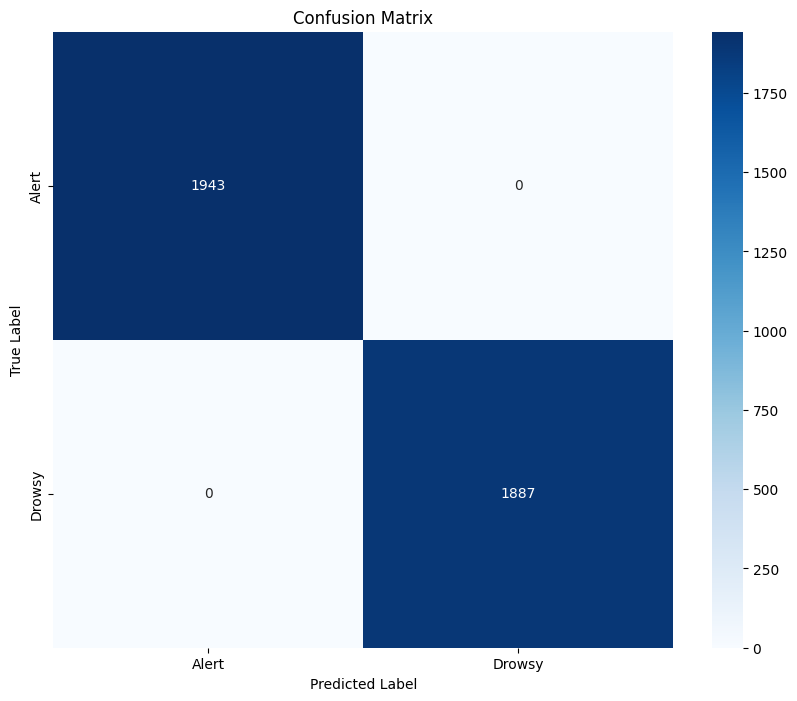

In [ ]:
class_names = ['Alert', 'Drowsy']

print("\n===== DETAILED EVALUATION =====")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def visualize_model_predictions(model, dataloader, device, num_samples=2, class_names=['Alert', 'Drowsy']):
    """
    Visualize model predictions for a few samples from each class.

    Args:
        model: Trained PyTorch model
        dataloader: DataLoader with samples
        device: Device to run inference on
        num_samples: Number of samples to visualize per class
        class_names: Names of classes
    """
    model.eval()
    samples_found = {0: 0, 1: 0}  # Count of samples found for each class
    total_needed = num_samples * len(class_names)

    # Store examples for visualization
    examples = []

    with torch.no_grad():
        for videos, labels in dataloader:
            if sum(samples_found.values()) >= total_needed:
                break

            # Send to device
            videos = videos.to(device)

            # Get predictions
            outputs = model(videos)
            _, preds = torch.max(outputs, 1)

            # Check each sample in the batch
            for i in range(len(labels)):
                label = labels[i].item()
                pred = preds[i].item()

                # If we need more samples of this class
                if samples_found[label] < num_samples:
                    # Add this example
                    examples.append({
                        'video': videos[i].cpu(),  # Shape: [T, C, H, W]
                        'true_label': label,
                        'pred_label': pred,
                        'correct': label == pred
                    })
                    samples_found[label] += 1

                # Break if we have enough samples
                if sum(samples_found.values()) >= total_needed:
                    break

    # Visualize found examples
    for i, example in enumerate(examples):
        video = example['video']
        true_label = example['true_label']
        pred_label = example['pred_label']

        # Plot all frames in the window
        fig, axes = plt.subplots(2, 8, figsize=(20, 5))
        fig.suptitle(f"Example {i+1}: True: {class_names[true_label]}, Predicted: {class_names[pred_label]}",
                     fontsize=16, color='green' if true_label == pred_label else 'red')

        for t in range(video.shape[0]):
            row, col = t // 8, t % 8
            frame = video[t].permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
            axes[row, col].imshow(frame)
            axes[row, col].set_title(f"Frame {t+1}")
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()


Visualizing model predictions...


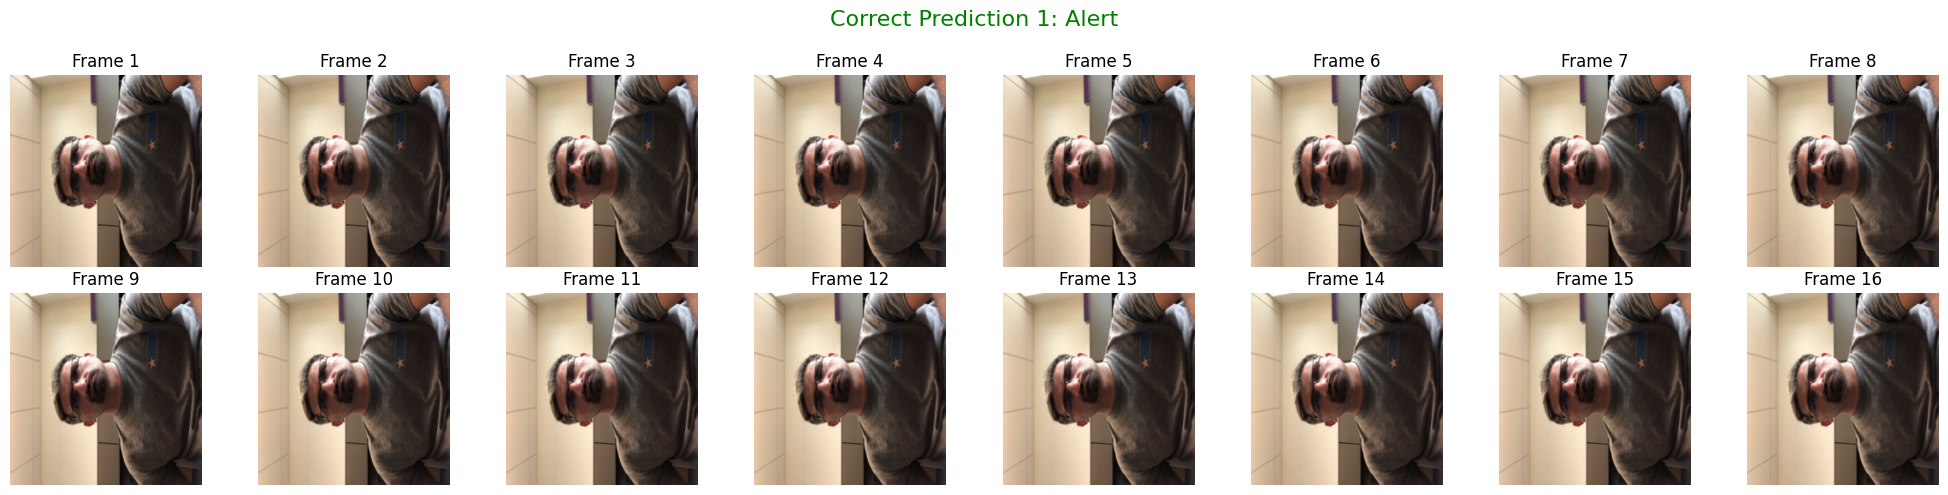

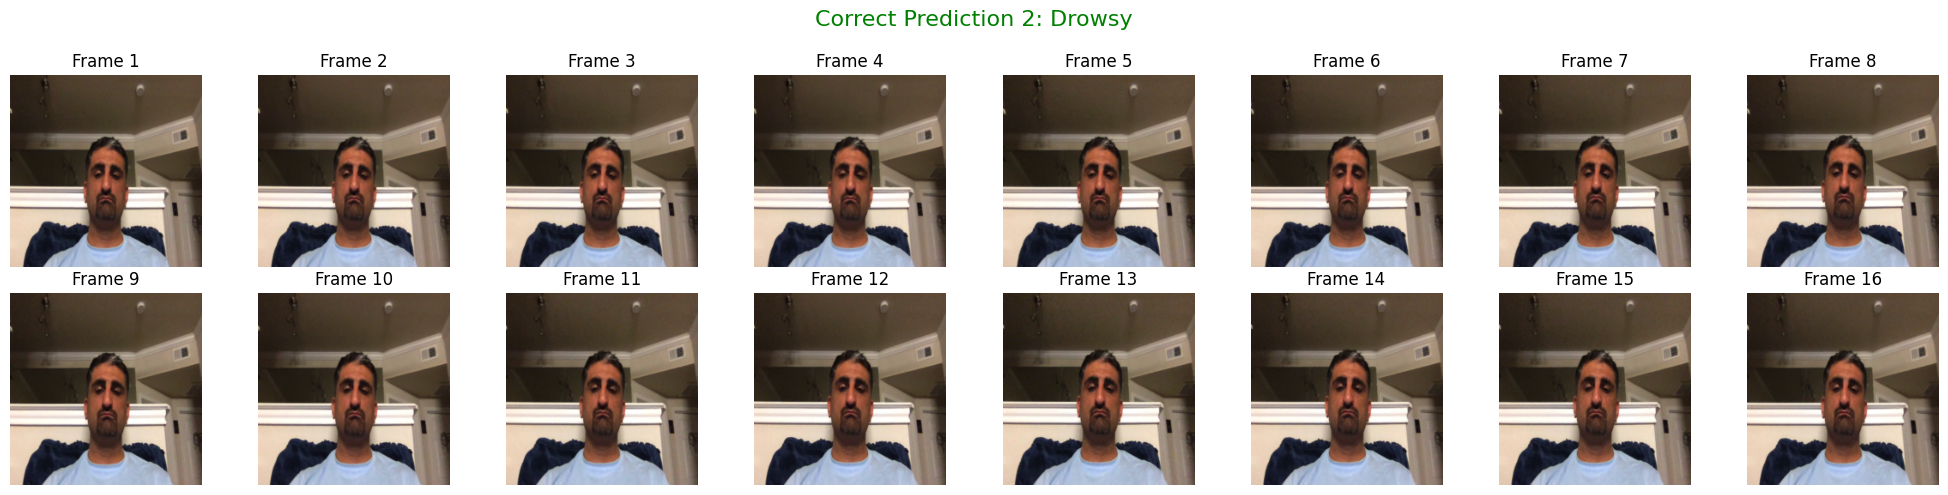

In [ ]:
# Visualize model predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("\nVisualizing model predictions...")
visualize_model_predictions(model, test_loader, device, num_samples=1)